The code has been implemented in PyTorch. For performing model extraction attacks and defense I use IBM Art.
<br>
title = Adversarial Robustness Toolbox v1.2.0
<br>
author = Nicolae, Maria-Irina and Sinn, Mathieu and Tran, Minh~Ngoc and Buesser, Beat and Rawat, Ambrish and Wistuba, Martin and Zantedeschi, Valentina and Baracaldo, Nathalie and Chen, Bryant and Ludwig, Heiko and Molloy, Ian and Edwards, Ben
<br>
year = 2018
<br>
url = https://arxiv.org/pdf/1807.01069
<br>
github = https://github.com/Trusted-AI/adversarial-robustness-toolbox

In [ ]:
!pip install adversarial-robustness-toolbox #Install IBM Art

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The code is importing various libraries and modules for machine learning and adversarial machine learning tasks. Here's a brief explanation of what each section does:

1. **Importing Libraries**:
   - Torch and Torchvision are imported for deep learning tasks.
   - Numpy and Pandas are imported for data manipulation.
   - Matplotlib is imported for data visualization.
   - The `%matplotlib inline` command is used to display Matplotlib plots in the Jupyter Notebook.
   - The `art` (Adversarial Robustness Toolbox) library is imported for adversarial machine learning.

2. **Creating a PyTorch Classifier**:
   - It is used to create a PyTorch-based classifier using the `PyTorchClassifier` class from the `art` library. This classifier can be used for adversarial attacks and defenses.

3. **Importing MNIST Dataset**:
   - The code loads the MNIST dataset which is used for training and evaluation.

4. **Importing Adversarial Attacks and Defenses**:
   - The code imports various adversarial attacks and defenses from the `art` library:
     - `ExtractionAttack`: This is the base class for adversarial extraction attacks.
     - `CopycatCNN`: An adversarial attack class that attempts to clone a target model by training a copycat model.
     - `KnockoffNets`: An adversarial attack class that attempts to extract a target model's architecture.
     - `GaussianNoise`: A post-processing defense technique that adds Gaussian noise to the model's outputs.
     - `ReverseSigmoid`: A post-processing defense technique that applies the reverse sigmoid function to model outputs.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import art
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import GaussianNoise
from art.defences.postprocessor import ReverseSigmoid


# Load the dataset, and split the test data into test and steal datasets. x_test0 will be further split to steal the model
In the code the following steps are performed to load a dataset, split it, and prepare it for further use:

1. **Load the Dataset**:
   - The code loads a dataset using the `load_mnist()` function. This is the MNIST dataset, which is a popular dataset of handwritten digits.
   - The dataset is loaded into variables `(x_train, y_train)` and `(x_test0, y_test0)`.

2. **Filtering and Reshaping Data**:
   - The code filters the training and test data to select samples where the target labels are either 0 or 1.
   - For both the training and test data, it rearranges the dimensions of the data using `np.transpose()` and reshapes it into a 2D format with 784 columns (28x28 image pixels).
   - The data is cast to the `float32` data type.

3. **Label Processing**:
   - For the training data (`y_train`), it appears that one-hot encoded labels are converted into class labels by taking the index of the maximum value along the columns (axis 1).
   - Similarly, for the test data (`y_test0`), one-hot encoded labels are converted into class labels in the same way.

The result of these operations is that you have filtered and reshaped training and test datasets with binary class labels (0 or 1) suitable for further processing, for a binary classification task.

In [ ]:
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
idx = (np.argmax(y_train,axis=1)==0)|(np.argmax(y_train,axis=1)==1)
x_train = np.transpose(x_train[idx], (0, 3, 1,2)).reshape(-1,784).astype('float32')
y_train = np.argmax(y_train[idx],axis=1)
idx = (np.argmax(y_test0,axis=1)==0)|(np.argmax(y_test0,axis=1)==1)
x_test0 = np.transpose(x_test0[idx], (0, 3, 1,2)).reshape(-1,784).astype('float32')
y_test0 = np.argmax(y_test0[idx],axis=1)

# Approximate Sigmoid function

The code defines an approximate sigmoid function called `sigmoid_approx`. This function takes an input value and returns an approximation of the sigmoid function's output. Here's a breakdown of how the function works:

- Input: `input` is the value for which you want to approximate the sigmoid function's output.

- Approximation Formula: The function uses the following formula to approximate the sigmoid function:

  ```
  sigmoid_approx(input) = 0.5 + 0.197 * input - 0.004 * input^3
  ```

  - `0.5` is added to the result, which centers the sigmoid-like curve around `0.5`.
  - `0.197 * input` is a linear term that contributes to the slope of the curve.
  - `- 0.004 * input^3` is a cubic term that adds curvature to the curve.

This function provides a simple and computationally efficient way to approximate the sigmoid function. While it may not be as accurate as the true sigmoid function, it can be useful in scenarios where a quick approximation is sufficient and computational resources are limited.

You can use this `sigmoid_approx` function by passing a value as its input, and it will return the approximate sigmoid-like output for that value.

In [ ]:
def sigmoid_approx(input):
    return  0.5 + 0.197*input - 0.004*input*input*input

The code defines two PyTorch models: `VictimModel` and `ThiefModel`. These models are used for binary classification tasks and both have a linear layer at their core, but they use different methods to apply the sigmoid activation function:

1. `VictimModel`:
   - `VictimModel` is a PyTorch neural network model for binary classification.
   - It consists of a single linear layer defined as `nn.Linear(784, 1)`, indicating that it takes an input of dimension 784 (28x28 pixels) and outputs a single scalar value.
   - In the `forward` method, after the linear transformation, it applies the `sigmoid_approx` function to the output of the linear layer, which approximates the sigmoid function.
   - The `out` values are then clipped to ensure they are within the range [0, 1], where values less than 0 are set to 0 and values greater than 1 are set to 1.

2. `ThiefModel`:
   - `ThiefModel` is another PyTorch neural network model for binary classification.
   - Like `VictimModel`, it also consists of a single linear layer with the same input and output dimensions.
   - In the `forward` method, it applies the standard sigmoid activation function to the output of the linear layer using `torch.sigmoid`.

Both models are designed for binary classification tasks, but `VictimModel` uses the `sigmoid_approx` function to approximate the sigmoid activation function, while `ThiefModel` uses the standard sigmoid function provided by PyTorch (`torch.sigmoid`).

These models are used for tasks like image classification, where they take flattened images of size 784 as input and predict binary class labels.

In [ ]:
#LR model using approximation
class VictimModel(nn.Module):
    def __init__(self):
        super(VictimModel, self).__init__()
        self.linear = nn.Linear(784, 1) #Input dimension is 784(28*28) and output is 1

    def forward(self, x):
        out = self.linear(x)
        # apply sigmoid approx function
        out = sigmoid_approx(out)
        #The outputs are not in range [0,1] in some cases. Therefore, the below step
        out[out<0] = 0
        out[out>1] = 1
        return out

#LR model using approximation
class ThiefModel(nn.Module):
    def __init__(self):
        super(ThiefModel, self).__init__()
        self.linear = nn.Linear(784, 1) #Input dimension is 784(28*28) and output is 1

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)#Sigmoid activation
        return out

In the code, a victim model is created and trained using the PyTorch framework. Here's a breakdown of the code:

1. `victim_model = VictimModel()`: This line creates an instance of the `VictimModel` class, which was defined earlier. This model will be used as the victim in the attack.

2. `criterion = nn.BCELoss()`: It defines the binary cross-entropy loss function, which is commonly used for binary classification problems.

3. `optimizer = torch.optim.SGD(victim_model.parameters(), lr=.001)`: This line sets up the stochastic gradient descent (SGD) optimizer for training the victim model. It specifies that the parameters of the `victim_model` should be optimized using SGD with a learning rate of 0.001.

4. `victim_classifier = PyTorchClassifier(...)`: Here, an instance of the PyTorchClassifier from the Adversarial Robustness Toolbox (ART) is created. This classifier wraps the `victim_model` and is configured for use in adversarial attacks and defenses. The important parameters include the model, loss function, optimizer, input shape, and the number of classes.

5. `victim_classifier.fit(x_train, y_train, batch_size=64, nb_epochs=30)`: This line trains the `victim_classifier` (which includes the `victim_model`) on the training data (`x_train` and `y_train`). It specifies a batch size of 64 and trains for 30 epochs.

6. `predictions = victim_classifier.predict(x_test0).squeeze()`: After training, the model is used to make predictions on the test data `x_test0`. The `.squeeze()` method is used to remove any unnecessary dimensions from the predictions.

7. `predictions = np.around(predictions)`: The predicted probabilities are rounded to either 0 or 1 to obtain binary class predictions.

8. `accuracy = ((predictions==y_test0).sum())/len(y_test0)`: The accuracy of the victim model is calculated by comparing its predictions to the ground truth labels (`y_test0`). The accuracy is then printed as a percentage.

In [ ]:
victim_model = VictimModel()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(victim_model.parameters(), lr=.001)
victim_classifier = PyTorchClassifier(
    model=victim_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=784,
    nb_classes=2,
)
victim_classifier.fit(x_train, y_train, batch_size=64, nb_epochs=30)
predictions = victim_classifier.predict(x_test0).squeeze()
predictions = np.around(predictions)
accuracy = ((predictions==y_test0).sum())/len(y_test0)
print(accuracy*100)

99.8581560283688


The code performs a series of attacks on a victim model and evaluates the accuracy of the stolen models. Here's a breakdown of the code:

1. `num_epochs = 20`: Specify the number of epochs for training the victim model during the attack.

2. `postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)`: Defines a postprocessing defense using the `ReverseSigmoid` method from the Adversarial Robustness Toolbox (ART). This defense is applied to the victim model to protect it from attacks.

3. `victim_classifier_protected = PyTorchClassifier(...)`: Creates a new instance of the `PyTorchClassifier` for the protected victim model. This classifier includes the victim model, loss function, optimizer, and the postprocessing defense.

4. `len_steal = 5000`: Specify the size of the dataset for stealing, which is 5000 samples.

5. `attack_catalogue`: Defines a dictionary containing different attack methods, such as "Probabilistic CopycatCNN," "Argmax CopycatCNN," "Probabilistic KnockoffNets," etc. These methods will be used to steal the victim model.

6. `results = []`: Initializes an empty list to store the results of the attack.

7. The code then enters a loop where it iterates over different values of `len_steal` (ranging from 100 to 2000 with a step size of 100). For each `len_steal` value, it performs the following steps:

   - It randomly selects a subset of the test data for stealing (`x_steal` and `y_steal`) and keeps the remaining test data for evaluation (`x_test` and `y_test`).
   
   - It iterates over the attack methods in the `attack_catalogue` dictionary.
   
   - For each attack method, it creates a `thief_model` and a `thief_classifier` based on the `ThiefModel` class defined earlier. The attack is then executed to steal the model.
   
   - The stolen model is used to make predictions on the remaining test data (`x_test`), and the accuracy of the stolen model is calculated.
   
   - The name of the attack method, the size of the stolen dataset, and the accuracy of the stolen model are printed.

   - The results (attack name, dataset size, and accuracy) are appended to the `results` list.

In [ ]:
num_epochs = 20
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2) # Preparing defense. Beta is a psotive magnitude parameter and gamma is a convergence parameter. Refer to https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/postprocessor.html
victim_classifier_protected = PyTorchClassifier(
    model=victim_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=784,
    nb_classes=2,
    postprocessing_defences = postprocessor
)

#Size of dataset for stealing
len_steal = 5000



criterion = nn.BCELoss()
optimizer = torch.optim.SGD(victim_model.parameters(), lr=.005)

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=victim_classifier,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=victim_classifier,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=victim_classifier,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=victim_classifier,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                     "Probabilistic CopycatCNN (Protected)": CopycatCNN(classifier=victim_classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (Protected)": CopycatCNN(classifier=victim_classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (Protected)": KnockoffNets(classifier=victim_classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (Protected)": KnockoffNets(classifier=victim_classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False)
                   }

results = []
for len_steal in range(100,2000,100):
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]
    for name, attack in attack_catalogue.items():
        thief_model = ThiefModel()
        thief_classifier = PyTorchClassifier(model=thief_model,clip_values=(0, 1),loss=criterion,optimizer=optimizer,input_shape=784,nb_classes=2)
        classifier_stolen = attack.extract(x_steal, thieved_classifier=thief_classifier)
        predictions = classifier_stolen.predict(x_test).squeeze()
        predictions = np.around(predictions)
        accuracy = ((predictions==y_test).sum())/len(y_test)
        print(name, ":", accuracy)
        results.append((name, len_steal, accuracy))

/usr/local/lib/python3.8/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:88: RuntimeWarning: divide by zero encountered in log
  sigmoid(-self.gamma * np.log((1.0 - preds_clipped_1) / preds_clipped_1)) - 0.5
/usr/local/lib/python3.8/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:91: RuntimeWarning: divide by zero encountered in true_divide
  sigmoid(-self.gamma * np.log((1.0 - preds_clipped_2) / preds_clipped_2)) - 0.5
/usr/local/lib/python3.8/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:91: RuntimeWarning: divide by zero encountered in log
  sigmoid(-self.gamma * np.log((1.0 - preds_clipped_2) / preds_clipped_2)) - 0.5


Probabilistic CopycatCNN : 0.19602977667493796
Argmax CopycatCNN : 0.567741935483871
Probabilistic KnockoffNets : 0.8044665012406947
Argmax KnockoffNets : 0.5652605459057072
Probabilistic CopycatCNN (Protected) : 0.34640198511166254
Argmax CopycatCNN (Protected) : 0.535483870967742


Probabilistic KnockoffNets (Protected) : 0.6382133995037221
Argmax KnockoffNets (Protected) : 0.49429280397022335


Probabilistic CopycatCNN : 0.5404699738903395
Argmax CopycatCNN : 0.5832898172323759
Probabilistic KnockoffNets : 0.8015665796344648
Argmax KnockoffNets : 0.42297650130548303


Probabilistic CopycatCNN (Protected) : 0.5608355091383812


Argmax CopycatCNN (Protected) : 0.6772845953002611
Probabilistic KnockoffNets (Protected) : 0.4135770234986945
Argmax KnockoffNets (Protected) : 0.31697127937336816


Probabilistic CopycatCNN : 0.2831955922865014


Argmax CopycatCNN : 0.3305785123966942
Probabilistic KnockoffNets : 0.22038567493112948
Argmax KnockoffNets : 0.668870523415978


Probabilistic CopycatCNN (Protected) : 0.5245179063360882
Argmax CopycatCNN (Protected) : 0.5327823691460055


Probabilistic KnockoffNets (Protected) : 0.6198347107438017
Argmax KnockoffNets (Protected) : 0.6578512396694215


Probabilistic CopycatCNN : 0.3323615160349854
Argmax CopycatCNN : 0.6932944606413994


Probabilistic KnockoffNets : 0.27405247813411077
Argmax KnockoffNets : 0.42857142857142855


Probabilistic CopycatCNN (Protected) : 0.49387755102040815
Argmax CopycatCNN (Protected) : 0.7854227405247813


Probabilistic KnockoffNets (Protected) : 0.7049562682215743
Argmax KnockoffNets (Protected) : 0.6845481049562682


Probabilistic CopycatCNN : 0.20061919504643963
Argmax CopycatCNN : 0.6309597523219814


Probabilistic KnockoffNets : 0.47306501547987617
Argmax KnockoffNets : 0.3219814241486068


Probabilistic CopycatCNN (Protected) : 0.648297213622291


Argmax CopycatCNN (Protected) : 0.44953560371517026
Probabilistic KnockoffNets (Protected) : 0.5157894736842106


Argmax KnockoffNets (Protected) : 0.20247678018575851


Probabilistic CopycatCNN : 0.4415841584158416
Argmax CopycatCNN : 0.3920792079207921


Probabilistic KnockoffNets : 0.7617161716171618
Argmax KnockoffNets : 0.3240924092409241
Probabilistic CopycatCNN (Protected) : 0.7643564356435644


Argmax CopycatCNN (Protected) : 0.6844884488448845
Probabilistic KnockoffNets (Protected) : 0.5128712871287129
Argmax KnockoffNets (Protected) : 0.5524752475247525


Probabilistic CopycatCNN : 0.21342756183745584
Argmax CopycatCNN : 0.9144876325088339
Probabilistic KnockoffNets : 0.1724381625441696


Argmax KnockoffNets : 0.6706713780918728
Probabilistic CopycatCNN (Protected) : 0.4925795053003534
Argmax CopycatCNN (Protected) : 0.4070671378091873


Probabilistic KnockoffNets (Protected) : 0.49823321554770317
Argmax KnockoffNets (Protected) : 0.3858657243816254
Probabilistic CopycatCNN : 0.10570342205323194


Argmax CopycatCNN : 0.5155893536121673
Probabilistic KnockoffNets : 0.379467680608365
Argmax KnockoffNets : 0.15285171102661596


Probabilistic CopycatCNN (Protected) : 0.5665399239543726
Argmax CopycatCNN (Protected) : 0.24866920152091254


Probabilistic KnockoffNets (Protected) : 0.6988593155893537
Argmax KnockoffNets (Protected) : 0.4220532319391635


Probabilistic CopycatCNN : 0.6551440329218107
Argmax CopycatCNN : 0.594238683127572


Probabilistic KnockoffNets : 0.37530864197530867


Argmax KnockoffNets : 0.5218106995884774


Probabilistic CopycatCNN (Protected) : 0.2740740740740741


Argmax CopycatCNN (Protected) : 0.1168724279835391


Probabilistic KnockoffNets (Protected) : 0.29958847736625516


Argmax KnockoffNets (Protected) : 0.6946502057613169


Probabilistic CopycatCNN : 0.6681614349775785


Argmax CopycatCNN : 0.6394618834080718


Probabilistic KnockoffNets : 0.42780269058295967


Argmax KnockoffNets : 0.4896860986547085


Probabilistic CopycatCNN (Protected) : 0.42869955156950673


Argmax CopycatCNN (Protected) : 0.36412556053811657


Probabilistic KnockoffNets (Protected) : 0.8197309417040358


Argmax KnockoffNets (Protected) : 0.2502242152466368


Probabilistic CopycatCNN : 0.15172413793103448


Argmax CopycatCNN : 0.5014778325123153


Probabilistic KnockoffNets : 0.47586206896551725


Argmax KnockoffNets : 0.1960591133004926


Probabilistic CopycatCNN (Protected) : 0.40492610837438425


Argmax CopycatCNN (Protected) : 0.38029556650246304


Probabilistic KnockoffNets (Protected) : 0.41576354679802957


Argmax KnockoffNets (Protected) : 0.44729064039408867


Probabilistic CopycatCNN : 0.4568306010928962


Argmax CopycatCNN : 0.585792349726776


Probabilistic KnockoffNets : 0.5191256830601093


Argmax KnockoffNets : 0.7442622950819672


Probabilistic CopycatCNN (Protected) : 0.5158469945355191


Argmax CopycatCNN (Protected) : 0.9475409836065574


Probabilistic KnockoffNets (Protected) : 0.594535519125683


Argmax KnockoffNets (Protected) : 0.6284153005464481


Probabilistic CopycatCNN : 0.3901840490797546


Argmax CopycatCNN : 0.588957055214724


Probabilistic KnockoffNets : 0.6220858895705521


Argmax KnockoffNets : 0.40245398773006136


Probabilistic CopycatCNN (Protected) : 0.21595092024539878


Argmax CopycatCNN (Protected) : 0.3276073619631902


Probabilistic KnockoffNets (Protected) : 0.7987730061349694


Argmax KnockoffNets (Protected) : 0.5742331288343558
Probabilistic CopycatCNN : 0.3076923076923077


Argmax CopycatCNN : 0.5664335664335665


Probabilistic KnockoffNets : 0.862937062937063


Argmax KnockoffNets : 0.16223776223776223


Probabilistic CopycatCNN (Protected) : 0.427972027972028


Argmax CopycatCNN (Protected) : 0.1944055944055944


Probabilistic KnockoffNets (Protected) : 0.2083916083916084


Argmax KnockoffNets (Protected) : 0.07132867132867132
Probabilistic CopycatCNN : 0.3252032520325203


Argmax CopycatCNN : 0.5886178861788618
Probabilistic KnockoffNets : 0.44065040650406506


Argmax KnockoffNets : 0.3723577235772358
Probabilistic CopycatCNN (Protected) : 0.3967479674796748


Argmax CopycatCNN (Protected) : 0.8520325203252033
Probabilistic KnockoffNets (Protected) : 0.35609756097560974


Argmax KnockoffNets (Protected) : 0.3804878048780488
Probabilistic CopycatCNN : 0.34368932038834954


Argmax CopycatCNN : 0.21553398058252426
Probabilistic KnockoffNets : 0.2058252427184466


Argmax KnockoffNets : 0.8601941747572815
Probabilistic CopycatCNN (Protected) : 0.7689320388349514


Argmax CopycatCNN (Protected) : 0.6446601941747573
Probabilistic KnockoffNets (Protected) : 0.40194174757281553


Argmax KnockoffNets (Protected) : 0.41941747572815535
Probabilistic CopycatCNN : 

0.5084337349397591
Argmax CopycatCNN : 0.5590361445783133


Probabilistic KnockoffNets : 0.2385542168674699


Argmax KnockoffNets : 0.44819277108433736


Probabilistic CopycatCNN (Protected) : 0.5204819277108433
Argmax CopycatCNN (Protected) : 0.26265060240963856


Probabilistic KnockoffNets (Protected) : 0.327710843373494


Argmax KnockoffNets (Protected) : 0.3542168674698795


Probabilistic CopycatCNN : 0.49206349206349204


Argmax CopycatCNN : 0.5968253968253968


Probabilistic KnockoffNets : 0.6857142857142857


Argmax KnockoffNets : 0.2920634920634921


Probabilistic CopycatCNN (Protected) : 0.49206349206349204


Argmax CopycatCNN (Protected) : 0.8285714285714286


Probabilistic KnockoffNets (Protected) : 0.6190476190476191


Argmax KnockoffNets (Protected) : 0.6730158730158731


Probabilistic CopycatCNN : 0.3581395348837209


Argmax CopycatCNN : 0.4790697674418605


Probabilistic KnockoffNets : 0.5674418604651162


Argmax KnockoffNets : 0.4930232558139535


Probabilistic CopycatCNN (Protected) : 0.7116279069767442


Argmax CopycatCNN (Protected) : 0.8837209302325582


Probabilistic KnockoffNets (Protected) : 0.4744186046511628
Argmax KnockoffNets (Protected) : 0.7302325581395349


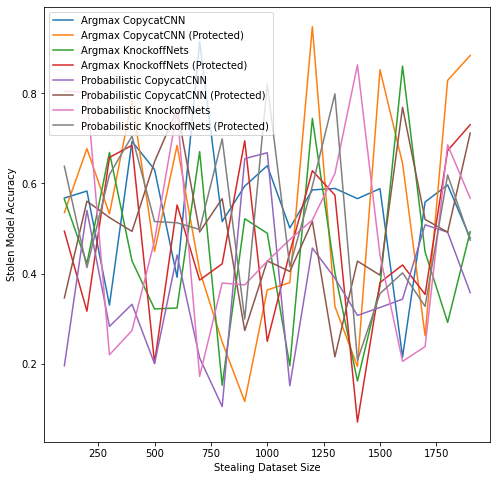

In [ ]:
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
groupby = df.groupby("Method Name")
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [ ]:
df.sort_values(by=['Accuracy'],ascending=False)

,Method Name,Stealing Dataset Size,Accuracy
93,Argmax CopycatCNN (Protected),1200,0.947541
49,Argmax CopycatCNN,700,0.914488
149,Argmax CopycatCNN (Protected),1900,0.883721
106,Probabilistic KnockoffNets,1400,0.862937
123,Argmax KnockoffNets,1600,0.860194
...,...,...,...
59,Argmax KnockoffNets,800,0.152852
80,Probabilistic CopycatCNN,1100,0.151724
69,Argmax CopycatCNN (Protected),900,0.116872
56,Probabilistic CopycatCNN,800,0.105703


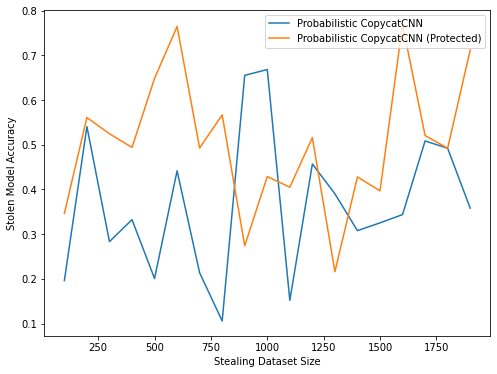

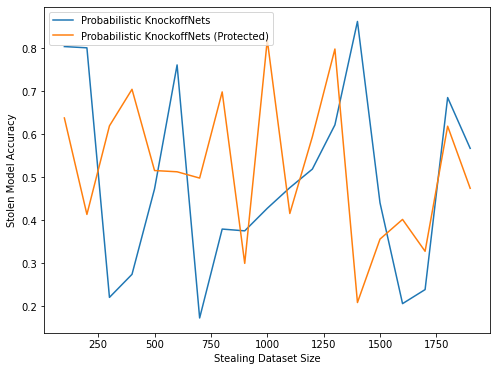

In [ ]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()